## Feature Selection, Compositional Data and Missingness

**Data** [Sources](2_Data_Sources.ipynb) | [Compositional Data](2_Data_CompositionalData.ipynb) | [Lambdas](2_Data_Lambdas.ipynb) **Classifiers** [Models](3_Classifiers_ClassifierModels.ipynb) | [Dimensionality](3_Classifiers_Dimensionality.ipynb) | [Performance](3_Classifiers_Performance.ipynb) **Visualisation**  [Entropy](4_Vis_Entropy.ipynb) | [Manifolds](4_Vis_Manifolds.ipynb) **Workflows** [Building Workflows](5_BuildingWorkflows.ipynb) **pyrolite** [Overview](6_pyrolite.ipynb) **GitHub** [AEGC2019](https://github.com/morganjwilliams/aegc2019) | [pyrolite](https://github.com/morganjwilliams/pyrolite)

* The performance of classifiers is typically closely linked to their dimensionality.
* With compositional data, missing data can be a central limitation to using higher dimensional datasets.
* Accessing dense high-dimensional datasets can be difficult, and carefully choosing a subset of variables is often the best course of action.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyrolite.util.skl.transform import CLRTransform
from pyrolite.util.skl.pipeline import SVC_pipeline
from pyrolite.geochem.ind import common_elements, common_oxides

Using TensorFlow backend.


In [2]:
df = pd.read_csv('https://storage.googleapis.com/aegc2019/ueki2018.csv')

majors = [i for i in df.columns if i in common_oxides(as_set=True)]
traces =[i for i in df.columns if i in common_elements(as_set=True)]
isotopes = [i for i in df.columns if i != "Class" and i not in majors+traces]

classes = {c: ix for ix, c in enumerate(df.Class.unique())}
X, y = CLRTransform().transform(df.loc[:, majors+traces+isotopes]), df["Class"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, 
                                                    test_size=0.3)
scores = {}
for name, feature_set in [('Majors', majors), 
                          ('Traces', traces), 
                          ('Isotopes', isotopes), 
                          ('T+I', traces+isotopes),
                          ('M+T', majors+traces),
                          ('M+I', majors+isotopes), 
                          ('All', majors+traces+isotopes)]:
    svc = SVC_pipeline(probability=True,
                       scaler=StandardScaler(),
                       kernel='rbf',
                       verbose=False)
    gs = svc.fit(X_train.loc[:, feature_set], 
                 y_train)
    scores[name] = dict(nfeatures=len(feature_set), 
                        score=gs.score(X_test.loc[:, feature_set], y_test))

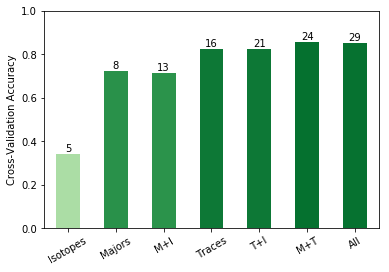

In [6]:
cm = plt.cm.Greens
sc = pd.DataFrame.from_dict(scores).T.sort_values('nfeatures')
ax = sc.score.plot.bar(legend=False, 
                       ylim=(0,1))

ax.set_ylabel('Cross-Validation Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
for ix, p in enumerate(ax.patches):
    p.set_facecolor(cm(sc.iloc[ix].score))
    ax.annotate(int(sc.iloc[ix].nfeatures), 
                xy=(ix, sc.iloc[ix].score), 
                ha='center', 
                va='bottom')

In [7]:
from pyrolite.util.plot import save_figure
save_figure(ax.figure, 
            name='DimensionsVAccuracy', 
            save_at="../presentation/figures/", 
            save_fmts=['pdf', 'png'])

### Discrimination Power of Multivariate Data

### Understanding Your Dataset

#### Correlation and Co-occurrence